In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np
import torchaudio
import torch


tensor(-103.7828) tensor(115.1181)
-0.42897514


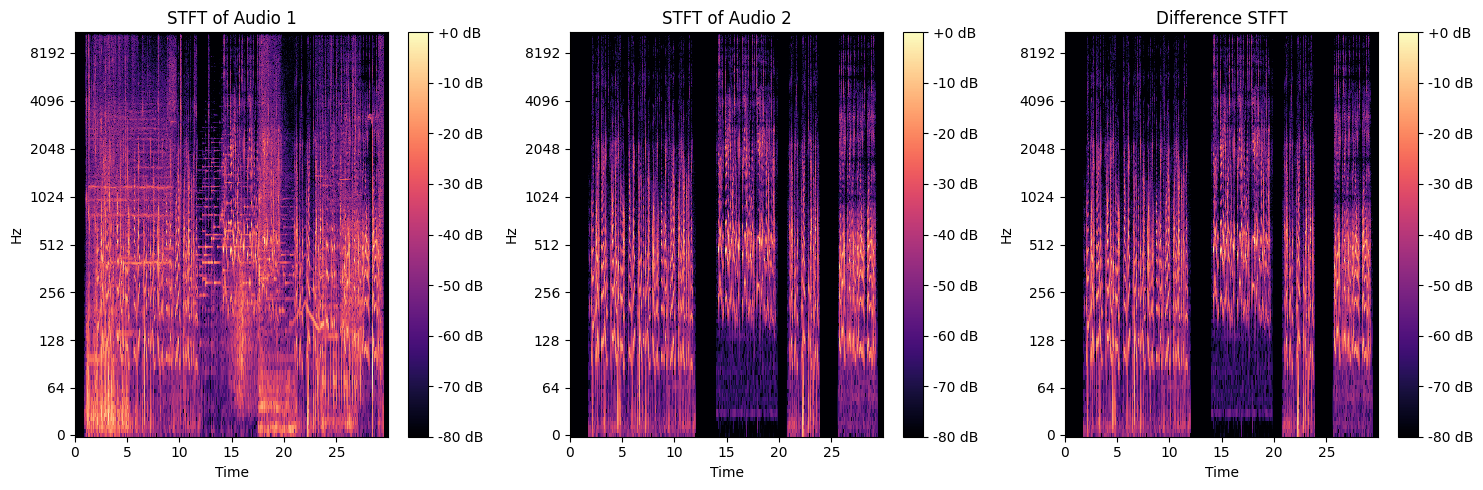

In [3]:
def process_audio(file1, file2, file3, file4):
    """Loads two audio files, calculates their STFTs, subtracts the difference, and displays the results."""
    n_fft=2**12
    try:
        # Load audio files
        y1, sr1 = librosa.load(file1)
        y2, sr2 = librosa.load(file2)
        y3, sr3 = librosa.load(file3)
        y4, sr4 = librosa.load(file4)

        y5 = y1 - (y3 + y4)

        # Check if sample rates are the same
        if sr1 != sr2:
            print(
                "Warning: Sample rates of the two audio files are different. Resampling to the first file's sample rate.")
            y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
            sr2 = sr1

        # Calculate STFTs
        stft1 = librosa.stft(y1, n_fft=n_fft)
        stft2 = np.abs(librosa.stft(y2,n_fft=n_fft))
        stft3 = np.abs(librosa.stft(y3,n_fft=n_fft))
        stft4 = np.abs(librosa.stft(y4,n_fft=n_fft))
        stft5 = librosa.stft(y5,n_fft=n_fft)
        c = torch.from_numpy(y5)
        c = torch.stft(c,n_fft=n_fft,window=torch.hann_window(n_fft),return_complex=True)
        d = torch.view_as_real(c)
        print(d.min(), d.max())
        print(y5.min())

        # Subtract the difference (handle potential shape mismatch)
        min_shape = min(stft1.shape[1], stft2.shape[1])
        diff_stft = stft1[:, :min_shape] - stft5[:, :min_shape]
        
        stft1 = np.abs(stft1)
        stft5 = np.abs(stft5)
        diff_stft = np.abs(diff_stft)

        # Plotting
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        librosa.display.specshow(librosa.amplitude_to_db(stft1, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 1')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 2)
        librosa.display.specshow(librosa.amplitude_to_db(stft2, ref=np.max), sr=sr2, y_axis='log', x_axis='time')
        plt.title('STFT of Audio 2')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(1, 3, 3)
        librosa.display.specshow(librosa.amplitude_to_db(stft5, ref=np.max), sr=sr1, y_axis='log', x_axis='time')
        plt.title('Difference STFT')
        plt.colorbar(format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("Error: One or both audio files not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage: Replace 'audio1.wav' and 'audio2.wav' with your file paths.
top_dir = "46841"
process_audio(f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/mix.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/speech.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/sfx.wav",
              f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/{top_dir}/music.wav")

In [9]:
import torchaudio
import torch

def separate_audio_by_frequency(audio_file_path, frequency_ranges,n_fft=8192):
    
    waveform, sample_rate = torchaudio.load(audio_file_path)
    waveform = waveform.mean(dim=0, keepdim=True) # Convert stereo to mono

    window = torch.hann_window(n_fft)
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=512, window=window, return_complex=True)
    print(stft.shape)

    frequency_bands = []
    for min_freq, max_freq in frequency_ranges:
      # Calculate frequency indices
      min_index = int(min_freq * n_fft / sample_rate)
      max_index = int(max_freq * n_fft / sample_rate)

      # Extract frequency bands from STFT
      band_stft = stft[:, min_index:max_index, :]
      t = torch.view_as_real(band_stft)
      diff = t.max() - t.min()
      print(t.min(), t.max())
      print(t.mean(),t.std())
      # band_waveform = torch.istft(band_stft, n_fft=n_fft, hop_length=512, window=window, length=waveform.shape[-1],onesided=False)
      frequency_bands.append(band_stft.squeeze())

    return frequency_bands

    


In [16]:
separate_audio_by_frequency(f"/Users/etemesi/PycharmProjects/Spite/data/dnr_v2/917/mix.wav",[(0,5000),(5000,10000),(10000,15000),(15000,20000),(20000,25000)],n_fft=2048)

torch.Size([1, 1025, 5168])
tensor(-79.9499) tensor(70.7716)
tensor(-0.0002) tensor(1.5593)
tensor(-8.9452) tensor(9.2539)
tensor(8.4272e-06) tensor(0.2457)
tensor(-32.8570) tensor(29.6634)
tensor(-4.4542e-06) tensor(0.1372)
tensor(-4.0805) tensor(3.8838)
tensor(6.7156e-07) tensor(0.0563)
tensor(-4.7714) tensor(4.5967)
tensor(-1.7491e-06) tensor(0.0360)


[tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.-0.j, 0.-0.j, 0.-0.j,  ..., 0.-0.j, 0.-0.j, 0.-0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.